<a href="https://colab.research.google.com/github/jeroenVerdonschot/pdok-converter-issues/blob/master/deepforest_test_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

create pdok URL

https://service.pdok.nl/hwh/luchtfotorgb/wms/v1_0?&request=GetMap&&VERSION=1.3.0&service=wms&&BBOX=217714.3148907632,541898.9563823964,%20218405.73214467987,542548.7543453006&CRS=EPSG:28992&WIDTH=4000&HEIGHT=3759&LAYERS=2020_ortho25&STYLES=&FORMAT=image/jpeg


pdok photo = 25cm => every pixel is 25cm in real world size
1000 px =  0.25*1000 = 250 meters

deep forest model is trained on 10cm per pixel 
100 meters = 1000px

PDOK tile 100x100 meters => 400px, 400px
DeepForest = 1000px, 1000px


Evaluation:

- BGT is niet up to date, klopt niet meer met huidige luchtfoto.
- Vaak staan grote beeldbepalende bomen op priveterrein en niet in de BGT.

In [1]:
pip install --upgrade deepforest albumentations pyyaml opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.0 MB 151 kB/s 
     |████████████████████████████████| 113 kB 57.4 MB/s 
     |████████████████████████████████| 596 kB 43.5 MB/s 
     |████████████████████████████████| 21.8 MB 49.1 MB/s 
     |████████████████████████████████| 19.3 MB 488 kB/s 
     |████████████████████████████████| 1.0 MB 58.2 MB/s 
     |████████████████████████████████| 1.0 MB 71.5 MB/s 
     |████████████████████████████████| 585 kB 73.9 MB/s 
     |████████████████████████████████| 31.0 MB 150 kB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 6.3 MB 48.9 MB/s 
     |████████████████████████████████| 16.7 MB 69.8 MB/s 
     |████████████████████████████████| 419 kB 54.0 MB/s 
     |████████████████████████████████| 140 kB 65.8 MB/s 
     |████████████████████████████████| 1.1 MB 69.3 MB/s 
     |███████████████████████

In [2]:
pip install --upgrade albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install psycopg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 144 kB 31.6 MB/s 
     |████████████████████████████████| 70 kB 9.9 MB/s 


In [4]:
# GLOBALS
PHOTO_RES_CM = 10 # target photo resolution (Deepforest 10cm, PDOK 25cm/8cm)

In [5]:
#@title
from io import BytesIO
import requests
import numpy as np 
from PIL import Image, ImageDraw, ImageOps

def load_image_to_np(url): 
    res = requests.get(url)
    if res.status_code == 200 and 'jpeg' in res.headers['content-type']:
        img_arr = np.array(Image.open(BytesIO(res.content)))
        return img_arr
    else: 
        print("ERROR", res, res.headers)
        return None

In [6]:
import psycopg
import json

def handle_query_array(n):
  return json.loads(n[0])['coordinates']

def send_query(query):
  conn = psycopg.connect(host="157.90.127.240", dbname="pdok_2", user="gis",password= "..Post001",port=54321)
  cur = conn.cursor()
  query_res = cur.execute(query).fetchall()
  conn.close()
  return map(handle_query_array, query_res)


In [7]:
import os
import time
import numpy as np
from deepforest import main 
from deepforest import get_data
from deepforest import utilities
from deepforest import preprocess

In [8]:
model = main.deepforest()
model.use_release()


Reading config file: /usr/local/lib/python3.7/dist-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

NEON.pt: 129MB [00:01, 99.6MB/s]                          


Model was downloaded and saved to /usr/local/lib/python3.7/dist-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [9]:
def load_input_img(filename, center, size):
  resolution = size/(PHOTO_RES_CM/100)
  url = make_url(resolution, center, size)
  response = requests.get(url)
  input_img = Image.open(BytesIO(response.content))
  input_img.save(filename)
  return input_img

In [10]:
def make_url(resolution, center, size):
  #https://service.pdok.nl/hwh/luchtfotorgb/wms/v1_0?&request=GetMap&&VERSION=1.3.0&service=wms&&BBOX=161202.7521829645,382275.0854247781, 161218.49783115726,382289.4842461864&CRS=EPSG:28992&WIDTH=4000&HEIGHT=3658&LAYERS=2021_orthoHR&STYLES=&FORMAT=image/jpeg
  LAYERS = '&LAYERS=2020_ortho25'
  #LAYERS = '&LAYERS=2021_orthoHR'
  #LAYERS = '&LAYERS=2020_ortho25IR'
  PHOTO_TYPE = 'rgb' # cir

  X_min = center[0]-size/2
  Y_min = center[1]-size/2
  X_max = center[0]+size/2
  Y_max = center[1]+size/2

  BBOX = f'&BBOX={X_min},{Y_min},{X_max},{Y_max}'
  width = X_max-X_min
  height = Y_max-Y_min

  if width >= height:
    height = round(height/width*resolution)
    width = resolution
  else:
    width = round(width/height*resolution)
    height= resolution
  SIZE = f'&WIDTH={width}&HEIGHT={height}'

  URL = f'https://service.pdok.nl/hwh/luchtfoto{PHOTO_TYPE}/wms/v1_0?&request=GetMap&&VERSION=1.3.0&service=wms{BBOX}&CRS=EPSG:28992{SIZE}{LAYERS}&STYLES=&FORMAT=image/jpeg'

  return URL

In [11]:
def get_bboxes_predict_trees(filename): 
  bboxes = model.predict_image(path=filename)
  arr = []
  for index, row in bboxes.iterrows():
    data = [round(row["xmin"]), round(row["ymin"]), row["xmax"], row["ymax"]]
    arr.append(data)
  return arr

In [12]:
def make_bbox(center, size):
  X_min = center[0]-size/2
  Y_min = center[1]-size/2
  X_max = center[0]+size/2
  Y_max = center[1]+size/2
  return [X_min, Y_min,X_max,Y_max]

def make_bbox_string(center, size):
  b = make_bbox(center, size)
  return f"{b[0]} {b[1]}, {b[0]} {b[3]}, {b[2]} {b[3]}, {b[2]} {b[1]}, {b[0]} {b[1]}"

In [13]:
# bbox = make_bbox([161150, 382250], 100)
# image_resolution = 1000

def get_BGT_points(center, size):
  image_resolution = size/(PHOTO_RES_CM/100)
  tableName = 'bgt.vegetatieobject'
  bbox = make_bbox(center, size)
  bbox_str = make_bbox_string(center, size)
  query = f"select st_asgeojson(st_curvetoline(geometrie)) as geometry from (select ST_MakePolygon(ST_GeomFromText('LINESTRING({bbox_str})',28992)) as p ) as poly, {tableName}  WHERE geometrie IS NOT NULL AND ST_geometrytype(geometrie) = 'ST_Point' AND geometrie && poly.p AND st_intersects(poly.p,st_curvetoline(geometrie))"
  d = send_query(query)
  n_points = []
  for p in list(d): 
    n_points.append((round((p[0]- bbox[0]))*10, image_resolution - round(p[1]-bbox[1])*10))
  return {"points": list(d), "normalized_points": n_points}

In [14]:
def draw_points(image, points, color):
  draw = ImageDraw.Draw(image)
  for p in points:
    shape = [p, (p[0]+10, p[1]+10)]
    draw.ellipse(shape, fill =color)
  return image

def draw_circles(image, circles, color):
  draw = ImageDraw.Draw(image)
  for p in circles:
    d = p['radius']
    x= p['center'][0]-round(d/2)
    y= p['center'][1]-round(d/2)
   
    shape = [(x,y), (x+d, y+d)]
    draw.ellipse(shape, outline =color, width= 2)
  return image

def draw_bboxes(image, bboxes, color):
  draw = ImageDraw.Draw(image)
  for bbox in bboxes:
    
    draw.rectangle(bbox, outline= color, width= 2)
  return image


In [85]:
def split_points_inside_outside(points, boundaries):
  is_inside = False
  points_within = []
  points_outside = []
  for p in points: 
    for b in boundaries:
      if p[0]>=b[0] and p[1]>=b[1] and p[0]<=b[2] and p[1]<=b[3] :
        is_inside = True
    
    if is_inside:
      points_within.append(p)
    else: 
      points_outside.append(p)
    is_inside = False
  return {"points_within": points_within,"points_without_bbox":points_outside} 

def split_bboxes_with_without_points(points, bboxes):
  has_point= False
  bboxes_with = []
  bboxes_without = []
  for b in bboxes: 
    for p in points:
      if p[0]>=b[0] and p[1]>=b[1] and p[0]<=b[2] and p[1]<=b[3] :
        has_point = True

    if has_point:
      bboxes_with.append(b)
      
    else: 
      bboxes_without.append(b)
    has_point = False
  return {"bboxes_with_points": bboxes_with,"bboxes_without_points":bboxes_without}

def get_center(bbox):
  return ((bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2)

def get_center_points_from_bboxes(bboxes):
  centers=[]
  for bbox in bboxes:
    centers.append(get_center(bbox))
  return {"points_from_prediction": centers}

def classify_points_and_bboxes(points, bboxes): #TODO rename c_points
  c_points = split_points_inside_outside(points, bboxes)
  c_bboxes = split_bboxes_with_without_points(points, bboxes)
  c_points.update(c_bboxes)
  
  c_points.update(get_center_points_from_bboxes(c_bboxes["bboxes_without_points"]))

  return c_points


points = [(20, 310.0), (280, 90.0), (70, 210.0), (940, 810.0), (300, 170.0), (830, 930.0), (980, 0.0), (520, 30.0)]
bboxes = [[812, 885, 922.0, 995.0], [79, 873, 134.0, 931.0], [862, 754, 912.0, 805.0], [264, 51, 336.0, 128.0], [286, 137, 354.0, 202.0], [153, 872, 243.0, 969.0], [564, 764, 637.0, 840.0], [403, 569, 469.0, 637.0], [467, 482, 548.0, 568.0], [706, 902, 787.0, 984.0], [765, 304, 826.0, 367.0], [479, 675, 521.0, 718.0], [617, 474, 684.0, 546.0], [123, 811, 192.0, 880.0], [798, 408, 864.0, 480.0], [554, 531, 603.0, 586.0], [61, 593, 123.0, 660.0], [55, 182, 105.0, 230.0], [442, 373, 520.0, 456.0], [530, 357, 597.0, 423.0], [842, 661, 917.0, 736.0], [728, 179, 798.0, 255.0], [682, 98, 754.0, 174.0], [14, 10, 161.0, 159.0]]

c = classify_points_and_bboxes(points, bboxes)
#c


In [24]:
def get_canopies(bboxes):
  canopies = []

  for bbox in bboxes:

    w = bbox[2]-bbox[0]
    h = bbox[3]-bbox[1]

    r = max(w,h)
    c = (bbox[0]+((bbox[2]-bbox[0]))/2,bbox[1]+((bbox[3]-bbox[1])/2))

    canopies.append({"radius": r, "center": c})
    
  return canopies

def filter_edge_bboxes( bboxes,image_size, threshold):

  max_X = image_size[0]-threshold
  max_Y = image_size[1]-threshold

  edge_bboxes = []
  valid_bboxess = []
  
  for bbox in bboxes:
    if bbox[3] > max_Y or bbox[1] < threshold or bbox[0] < threshold or bbox[2] > max_X: 
      edge_bboxes.append(bbox)
    else:
      valid_bboxess.append(bbox)

  return {"edge_bboxes":edge_bboxes, "valid_bboxes": valid_bboxess}


In [70]:
def build_dataset(points, bboxes, img): #bboxes are predicted bboxes
  response_dict = {}
  debug = {}

  filtered_bboxes = filter_edge_bboxes(bboxes,img.size, 4)
  valid_bboxes = filtered_bboxes['valid_bboxes']
  debug.update({"invalid_bboxes_edge": filtered_bboxes['edge_bboxes']})

  by_color = split_bboxes_by_color(img, valid_bboxes, points)
  print(by_color)
  debug.update({'by_color': by_color})

  green_bboxes = get_bboxes_by_color(img,valid_bboxes,points)

  split_points = classify_points_and_bboxes(points, green_bboxes)
  response_dict.update(split_points)

  response_dict.update({"valid_bboxes": green_bboxes})
  response_dict.update({'debug': debug})

  #response_dict.update({"trees_from_prediction": [{"center": [0,0], "diameter": 0}]})
  #response_dict.update({"trees_with_bgt": [{"center": [0,0], "diameter": 0}]})

  return response_dict
  


In [47]:
from PIL import ImageStat
import colorsys

def is_within(bbox, points):
  for point in points:
    if point[0]>=bbox[0] and point[1]>=bbox[1] and point[0]<=bbox[2] and point[1]<=bbox[3]:
      return True
  return False

def split_bboxes_by_color(img, bboxes,verified_points=[]): 
  split_hsv={"red":[], "blue":[], "green":[], "grey": [], "light": []}
  for bbox in bboxes:
    im_crop = img.crop(bbox)
    avg_color = ImageStat.Stat(im_crop).median
    cs = colorsys.rgb_to_hsv(avg_color[0]/255,avg_color[1]/255, avg_color[2]/255)
    hsv = (round(cs[0]*360), round(cs[1]*100), round(cs[2]*100))
    if len(verified_points)>0 and is_within(bbox, verified_points):
      cat="green"
    else:
      cat = categorize_by_color(hsv)
    
    split_hsv[cat].append({"bbox": bbox , "avg_color":avg_color, "hsv_color": hsv})
 
  return split_hsv

HUE_RG_BOUNDARY = 70
HUE_GB_BOUNDARY = 210
SAT_MIN_BOUNDARY  = 3
VAL_MAX_BOUNDARY = 60

def categorize_by_color(v):
    if v[2] > VAL_MAX_BOUNDARY:
      return "light"
    if v[0] < HUE_RG_BOUNDARY: 
      return "red"
    if v[0] > HUE_GB_BOUNDARY:
      return "blue"
    if v[1] < SAT_MIN_BOUNDARY:
      print("grey", v[1])
      return "grey"
    return "green"

def get_bboxes_by_color(img, bboxes,verified_points,label="green"):
  _bboxes=[]
  split_hsv=split_bboxes_by_color(img,bboxes, verified_points)
  for v in split_hsv[label]:
    _bboxes.append(v["bbox"])
  return _bboxes

def filter_dict_by_key(obj, key):
  r = []
  for v in obj:
    r.append(v[key])
  return r


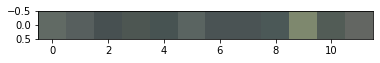

In [20]:
data = [[(97, 106, 100), (87, 95, 94), (71, 80, 81), (77, 86, 82), (71, 83, 82), (90, 100, 97), (74, 83, 84), (74, 83, 84), (75, 88, 87), (126, 136, 110), (82, 92, 86), (99, 102, 98)]]
import matplotlib.pyplot as plt

def drawPalette(data, label=""):
  plt.title(label)
  pixel_plot = plt.imshow(data, cmap='twilight', interpolation='nearest')
  #plt.savefig('pixel_plot.png')
  plt.show(pixel_plot)

drawPalette(data)

{'red': [{'bbox': [610, 323, 700.0, 408.0], 'avg_color': [120, 118, 107], 'hsv_color': (51, 11, 47)}, {'bbox': [339, 659, 417.0, 735.0], 'avg_color': [126, 127, 118], 'hsv_color': (67, 7, 50)}], 'blue': [{'bbox': [481, 586, 555.0, 664.0], 'avg_color': [77, 77, 89], 'hsv_color': (240, 13, 35)}, {'bbox': [561, 200, 653.0, 290.0], 'avg_color': [113, 105, 111], 'hsv_color': (315, 7, 44)}], 'green': [{'bbox': [776, 382, 861.0, 475.0], 'avg_color': [113, 122, 106], 'hsv_color': (94, 13, 48)}, {'bbox': [560, 576, 687.0, 709.0], 'avg_color': [93, 106, 94], 'hsv_color': (125, 12, 42)}, {'bbox': [311, 884, 419.0, 994.0], 'avg_color': [93, 106, 93], 'hsv_color': (120, 12, 42)}, {'bbox': [426, 782, 508.0, 866.0], 'avg_color': [97, 108, 95], 'hsv_color': (111, 12, 42)}, {'bbox': [678, 730, 744.0, 800.0], 'avg_color': [99, 109, 95], 'hsv_color': (103, 13, 43)}, {'bbox': [656, 155, 732.0, 232.0], 'avg_color': [98, 107, 96], 'hsv_color': (109, 10, 42)}, {'bbox': [361, 753, 413.0, 806.0], 'avg_color': 

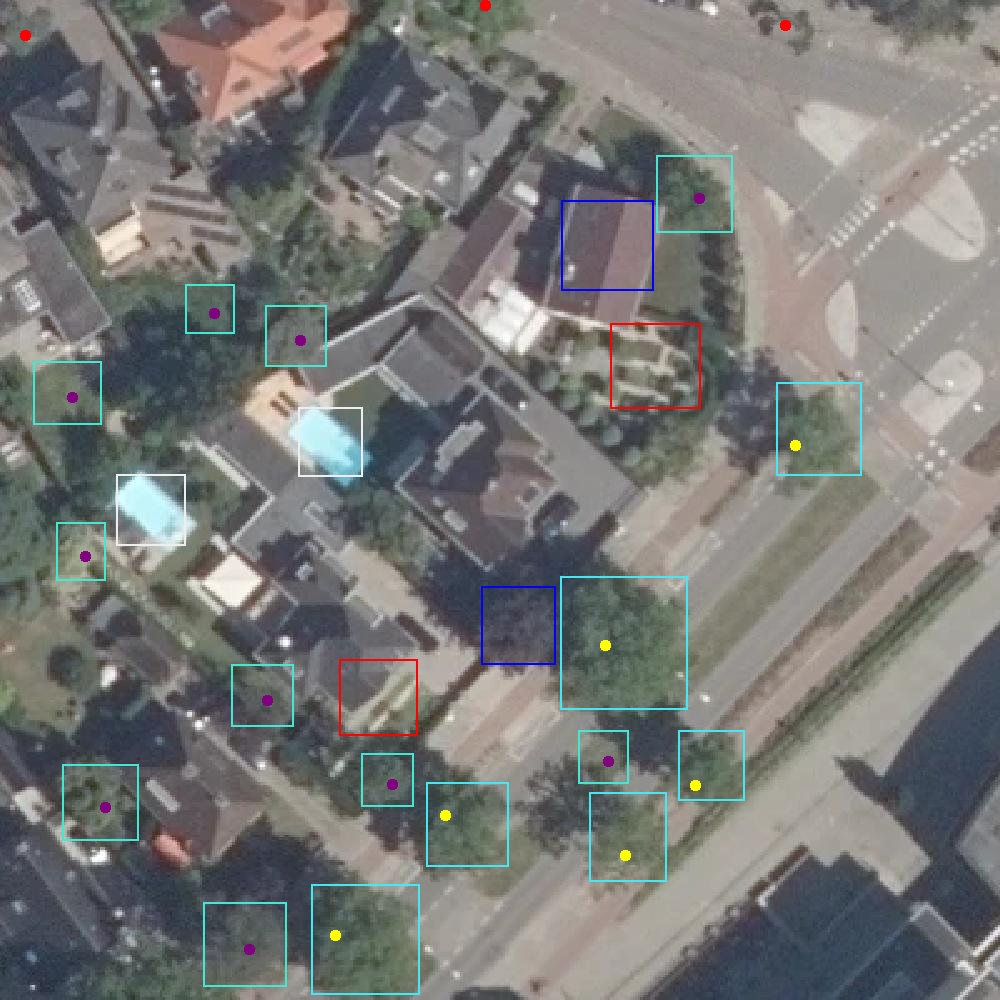

In [86]:
# flow 1 => get image with BGT points and predicted boxes
center =[161700, 382250] #161100, 382250 #160000, 380000
size = 100
PHOTO_RES_CM = 10
filename="input01.png"

# load image from PDOK
input_img = load_input_img(filename, center, size)

# predict image
bboxes = get_bboxes_predict_trees(filename)

#get BGT points (matching the image)
verified_points = get_BGT_points(center, size)['normalized_points'] #PHOTO_RES_CM TODO

#make object/dict
data = build_dataset(verified_points, bboxes, input_img)

# draw data on the input image
img = input_img
# n_ps = split_points_inside_outside(bgt_points, bboxes)
img = draw_points(img, data['points_within'], "yellow") # get all points
img = draw_points(img, data['points_without_bbox'], "red") # get all points
img = draw_points(img, data['points_from_prediction'], "green") # get all points
img = draw_bboxes(img, data['bboxes_with_points'], "#42e9f5")
img = draw_bboxes(img, data['bboxes_without_points'], "#42e9d2")
img = draw_bboxes(img, filter_dict_by_key(data['debug']['by_color']['red'], 'bbox'), "red")
img = draw_bboxes(img, filter_dict_by_key(data['debug']['by_color']['blue'], 'bbox'), "blue")
img = draw_bboxes(img, filter_dict_by_key(data['debug']['by_color']['grey'], 'bbox'), "#888")
img = draw_bboxes(img, filter_dict_by_key(data['debug']['by_color']['light'], 'bbox'), "#eee")
# img = draw_circles(img, canopies, "#a7f542")
img

# average color checking


In [79]:
 data['points_without_bbox']

[(780, 20.0), (480, 0.0), (20, 30.0)]

In [ ]:
img.save(f"/content/drive/MyDrive/mapconverter/error_0607_{center[0]}_{center[1]}_IR.png")

In [57]:
import json
j = json.dumps(data)
print(j)

{"points_within": [[960, 70.0], [370, 940.0], [240, 590.0], [760, 830.0], [860, 270.0], [750, 920.0], [150, 390.0], [680, 910.0], [480, 550.0], [860, 860.0], [340, 490.0], [60, 490.0]], "points_without_bbox": [[990, 10.0], [870, 20.0], [560, 820.0], [570, 850.0], [630, 810.0], [450, 810.0], [620, 510.0], [810, 920.0], [950, 880.0], [580, 980.0], [690, 360.0], [750, 480.0], [800, 680.0], [850, 1000.0]], "bboxes_with_points": [[791, 210, 909.0, 315.0], [293, 839, 456.0, 994.0], [196, 518, 303.0, 618.0], [15, 411, 122.0, 518.0], [749, 803, 811.0, 863.0], [827, 830, 906.0, 908.0], [298, 436, 390.0, 523.0], [438, 515, 504.0, 582.0], [734, 898, 786.0, 948.0], [121, 352, 197.0, 421.0], [949, 40, 991.0, 82.0], [672, 880, 715.0, 922.0]], "bboxes_without_points": [[510, 467, 617.0, 577.0], [374, 620, 455.0, 703.0], [920, 144, 988.0, 216.0], [282, 129, 353.0, 198.0], [516, 79, 582.0, 147.0], [415, 441, 469.0, 497.0], [879, 797, 934.0, 845.0], [795, 475, 880.0, 566.0]], "points_from_prediction": [

color: red [[120, 118, 107], [126, 127, 118]]
color: blue [[77, 77, 89], [113, 105, 111]]
color: grey []
color: light [[190, 221, 226], [172, 207, 214]]


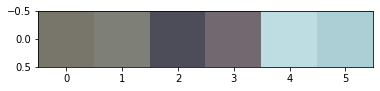

In [74]:
def show_invalid_colors(dataset):
  all = ["red", "blue", "grey", "light"]
  pal = []
  for a in all:
    cls = filter_dict_by_key(dataset['debug']['by_color'][a], 'avg_color')
    pal = pal+cls
    print (f"color: {a}",   cls)

  drawPalette([pal])
show_invalid_colors(data)

In [ ]:
def get_GeoJson(bboxs, bgt_points, skip_edge_bboxes = True):
  #bgt_points (attribute: canopySize, isValidated: true/false), bboxes, 

# load image from PDOK
  input_img = load_input_img(filename, center, size)

# predict image
  bboxes = get_bboxes_predict_trees(filename)
  filtered_bboxes = filter_edge_bboxes(bboxes,input_img.size, 4)

  # filtered bgt_points
  bgt_points = get_BGT_points(center, size)

  #match bgt_points with bboxes
  n_ps = split_points_inside_outside(bgt_points['normalized_points'], bboxes)

  #canopies = get_canopies(filtered_bboxes['valid_bboxess'])
  canopies = get_canopies(filtered_bboxes['matched_bboxess'])
  




In [ ]:
# import matplotlib.pyplot as plt
# import colorsys

# def get_dominant_color_palette(img, bboxes):
#   palette = []
#   _data=[]

#   for bbox in bboxes:
#     c = get_dominant_color_value_bbox(img, bbox)
   
#     # cs = colorsys.rgb_to_hsv(c[0]/255, c[1]/255, c[2]/255)

#     # fc = (cs[0]*360, cs[1]*100, cs[2]*100)
#     # if cs[0]*360 > 190: 
#     #   t="blue"
#     # elif cs[0]*360 < 70 : 
#     #   t="red"
#     # elif cs[1]*100 <3:
#     #   t="gray"
#     # else:
#     #   t="green"
#     # palette.append([cs[0]*360, cs[1]*100, t])
#     palette.append(c)

#   return palette

# import colorsys
# def get_dominant_color_value_bbox(img, bbox):
#   # get part of image
#   im_crop = img.crop(bbox)
#   im_crop.save("TEMP_CROP.png")

#   color_thief = ColorThief('TEMP_CROP.png')
#   # get the dominant color
#   d= color_thief.get_color(quality=1)
  
#   return d

# def get_avg_color_bbox(img, bbox):
  
#   return
